# Universidad Cenfotec
## Escuela de Fundamentos
### Curso: FIS-01 Física 1 FCV1

**Nombre:** Kevin Cervantes Melgar

**Tema:** Vectores de posición, velocidad y aceleración

---

## Índice
- Parte teórica
- Parte práctica

---

## Parte teórica
En esta sección se explican los conceptos fundamentales de los vectores de posición, velocidad y aceleración en dos y tres dimensiones.

### Vectores fundamentales

**Vector de posición**

$$
\vec{r} = x\,\hat{\imath} + y\,\hat{\jmath} + z\,\hat{k}
$$

**Velocidad instantánea**

$$
\vec{v} = \frac{d\vec{r}}{dt}, \qquad v_x=\frac{dx}{dt},\quad v_y=\frac{dy}{dt},\quad v_z=\frac{dz}{dt}
$$

**Aceleración instantánea**

$$
\vec{a} = \frac{d\vec{v}}{dt}, \qquad a_x=\frac{dv_x}{dt},\quad a_y=\frac{dv_y}{dt},\quad a_z=\frac{dv_z}{dt}
$$

---

## Parte práctica
En esta sección se presentan ejercicios y actividades para aplicar los conceptos de vectores de posición, velocidad y aceleración.

### Ejemplo resuelto

**Enunciado:**  
Un vehículo robot está explorando la superficie de Marte.  
El módulo de descenso estacionario es el origen de coordenadas, y la superficie marciana está en el plano $xy$.  
El vehículo (punto) tiene coordenadas:

$$
x(t) = 2.0~\text{m} - (0.25~\text{m/s}^2)t^2, \\
\quad
y(t) = (1.0~\text{m/s})t + (0.025~\text{m/s}^3)t^3
$$

**Tareas:**  
a) Obtenga las coordenadas del vehículo y su distancia al módulo en $t=2.0\ \text{s}$.  
b) Vectores desplazamiento y velocidad media de $t=0$ a $t=2.0\ \text{s}$.  
c) Expresión general del vector velocidad instantánea y su valor en $t=2.0\ \text{s}$ (componentes, módulo y dirección).  
d) Componentes de la aceleración media de $0$ a $2.0\ \text{s}$.  
e) Aceleración instantánea en $t=2.0\ \text{s}$.


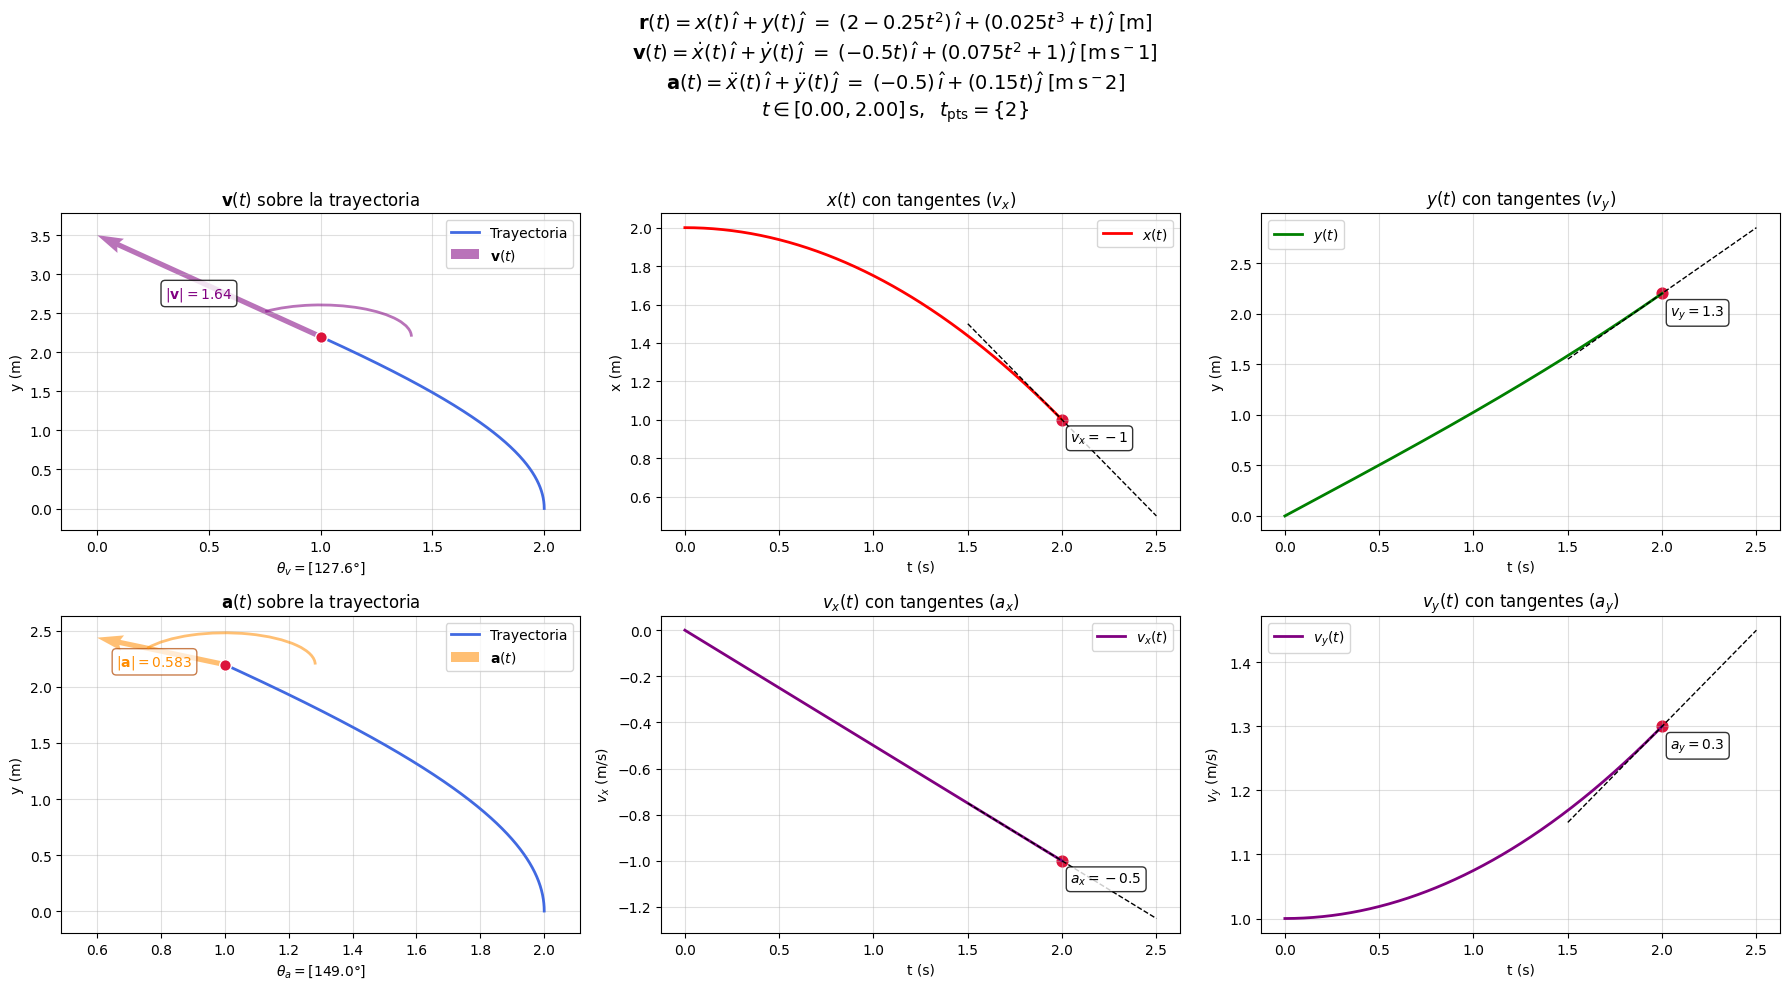

In [1]:
# === INTERFAZ CON BOTONES + GRAFICADOR AUTO-ADAPTATIVO ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import sympy as sp
from ipywidgets import Text, BoundedFloatText, IntSlider, Button, HBox, VBox, Layout, HTML
from IPython.display import display, clear_output
from html import escape
import re

# ---------------- Sanitizador de expresiones (pega desde Word/Docs sin romper) ----------------
def sanitize_expr(s: str) -> str:
    repl = {
        '–': '-', '—': '-', '−': '-',      # variantes de menos
        '×': '*', '·': '*', '∗': '*',      # multiplicación
        '⁄': '/', '÷': '/',                # división
        'π': 'pi'
    }
    for k, v in repl.items():
        s = s.replace(k, v)
    s = s.replace('^', '**')               # potencias
    # opcional: compactar espacios alrededor de operadores
    s = re.sub(r'\s*([\+\-\*/\^\(\)])\s*', r'\1', s)
    return s

# ---------------- Widgets (entradas) ----------------
x_box = Text(value="2 - 0.25*t**2", description="x(t) =", layout=Layout(width="420px"))
y_box = Text(value="1*t + 0.025*t**3", description="y(t) =", layout=Layout(width="420px"))
t0_w  = BoundedFloatText(value=0.0, min=-1e6, max=1e6, step=0.1, description="t₀")
t1_w  = BoundedFloatText(value=2.0, min=-1e6, max=1e6, step=0.1, description="t₁")
N_w   = IntSlider(value=400, min=50, max=2000, step=50, description="N puntos", continuous_update=False)
pts_box = Text(value="0, 1, 2", description="t_pts =", layout=Layout(width="240px"))
go_btn = Button(description="Graficar", button_style="primary")
msg    = HTML(value="")

ui = VBox([
    HBox([x_box, y_box]),
    HBox([t0_w, t1_w, N_w, pts_box, go_btn]),
    msg
])
display(ui)

# ---------------- Utilidades robustas ----------------
def to_array_like(val, like):
    like_arr = np.asarray(like)
    if np.isscalar(val):
        return np.broadcast_to(val, like_arr.shape).astype(float)
    a = np.asarray(val)
    if a.shape == ():
        return np.broadcast_to(float(a), like_arr.shape)
    return a

def parse_and_build(x_str, y_str):
    t = sp.symbols('t')
    locals_ok = {'t': t, 'sin': sp.sin, 'cos': sp.cos, 'tan': sp.tan,
                 'exp': sp.exp, 'log': sp.log, 'sqrt': sp.sqrt, 'abs': sp.Abs,
                 'pi': sp.pi, 'e': sp.E}

    x_str = sanitize_expr(x_str)
    y_str = sanitize_expr(y_str)

    x_expr = sp.sympify(x_str, locals=locals_ok)
    y_expr = sp.sympify(y_str, locals=locals_ok)

    vx_expr = sp.diff(x_expr, t)
    vy_expr = sp.diff(y_expr, t)
    ax_expr = sp.diff(vx_expr, t)
    ay_expr = sp.diff(vy_expr, t)

    # Lambdify
    x_fn  = sp.lambdify(t, x_expr,  'numpy')
    y_fn  = sp.lambdify(t, y_expr,  'numpy')
    vx_fn = sp.lambdify(t, vx_expr, 'numpy')
    vy_fn = sp.lambdify(t, vy_expr, 'numpy')
    ax_fn = sp.lambdify(t, ax_expr, 'numpy')
    ay_fn = sp.lambdify(t, ay_expr, 'numpy')

    # LaTeX
    x_tex,  y_tex  = sp.latex(x_expr),  sp.latex(y_expr)
    vx_tex, vy_tex = sp.latex(vx_expr), sp.latex(vy_expr)
    ax_tex, ay_tex = sp.latex(ax_expr), sp.latex(ay_expr)

    return (x_fn, y_fn, vx_fn, vy_fn, ax_fn, ay_fn,
            x_tex, y_tex, vx_tex, vy_tex, ax_tex, ay_tex)

def add_angle_arc(axaxes, cx, cy, ang_deg, radius, color, zorder=4, alpha=0.55):
    t1, t2 = (ang_deg, 0.0) if ang_deg < 0 else (0.0, ang_deg)
    arc = Arc((cx, cy), width=2*radius, height=2*radius,
              angle=0.0, theta1=t1, theta2=t2,
              color=color, lw=2, zorder=zorder, alpha=alpha)
    axaxes.add_patch(arc)

def pad_limits(x_vals, y_vals, extra_x=(), extra_y=(), frac=0.08):
    x_all = np.array(list(np.ravel(x_vals)) + list(np.ravel(extra_x)))
    y_all = np.array(list(np.ravel(y_vals)) + list(np.ravel(extra_y)))
    x_min, x_max = x_all.min(), x_all.max()
    y_min, y_max = y_all.min(), y_all.max()
    xr = max(1e-12, x_max - x_min); yr = max(1e-12, y_max - y_min)
    px = xr*frac; py = yr*frac
    return (x_min - px, x_max + px, y_min - py, y_max + py)

def rel_arc_radius(ax, frac=0.10):
    x0,x1 = ax.get_xlim(); y0,y1 = ax.get_ylim()
    return frac * max(abs(x1-x0), abs(y1-y0))

def unit(vx, vy, eps=1e-9):
    n = (vx**2 + vy**2)**0.5
    return (0.0, 0.0) if n < eps else (vx/n, vy/n)

# ---------------- Graficador (SIN vectores r) ----------------
def plot_all(x_fn, y_fn, vx_fn, vy_fn, ax_fn, ay_fn,
             x_tex, y_tex, vx_tex, vy_tex, ax_tex, ay_tex,
             t0, t1, N, t_pts):

    # Estilo
    FIGSIZE=(18,10); WSPACE=0.35; HSPACE=0.35
    scale_v_xy=1.0; scale_a_xy=0.8
    ASPECT_EQUAL=False
    MID_V_LABEL_OFFSET=9; MID_A_LABEL_OFFSET=9
    COLOR_TRAJ='royalblue'; COLOR_V='purple'
    COLOR_A='darkorange'; COLOR_A_LABEL='#b34700'

    # Mallado + evaluación con broadcast seguro
    T   = np.linspace(t0, t1, int(N))
    X   = to_array_like(x_fn(T), T);   Y   = to_array_like(y_fn(T), T)
    Xp  = to_array_like(x_fn(t_pts), t_pts);  Yp  = to_array_like(y_fn(t_pts), t_pts)
    Vxp = to_array_like(vx_fn(t_pts), t_pts); Vyp = to_array_like(vy_fn(t_pts), t_pts)
    Axp = to_array_like(ax_fn(t_pts), t_pts); Ayp = to_array_like(ay_fn(t_pts), t_pts)

    speed_v     = np.hypot(Vxp, Vyp)
    theta_v_deg = np.degrees(np.arctan2(Vyp, Vxp))
    speed_a     = np.hypot(Axp, Ayp)
    theta_a_deg = np.degrees(np.arctan2(Ayp, Axp))

    fig, axes = plt.subplots(2, 3, figsize=FIGSIZE)
    plt.subplots_adjust(wspace=WSPACE, hspace=HSPACE)
    ax1, ax2, ax3 = axes[0]; ax4, ax5, ax6 = axes[1]

    # ---------- Suptitle con los 3 vectores en unitarios + UNIDADES ----------
    t_list = ", ".join(f"{tp:g}" for tp in t_pts)

    fig.suptitle(
        # r(t) [m]
        rf"$\mathbf{{r}}(t)=x(t)\,\hat{{\imath}}+y(t)\,\hat{{\jmath}}"
        rf"\;=\;({x_tex})\,\hat{{\imath}}+({y_tex})\,\hat{{\jmath}}"
        rf"\;[\mathrm{{m}}]$" + "\n" +
        # v(t) [m s^{-1}]
        rf"$\mathbf{{v}}(t)=\dot x(t)\,\hat{{\imath}}+\dot y(t)\,\hat{{\jmath}}"
        rf"\;=\;({vx_tex})\,\hat{{\imath}}+({vy_tex})\,\hat{{\jmath}}"
        rf"\;[\mathrm{{m\,s^{-1}}}]$" + "\n" +
        # a(t) [m s^{-2}]
        rf"$\mathbf{{a}}(t)=\ddot x(t)\,\hat{{\imath}}+\ddot y(t)\,\hat{{\jmath}}"
        rf"\;=\;({ax_tex})\,\hat{{\imath}}+({ay_tex})\,\hat{{\jmath}}"
        rf"\;[\mathrm{{m\,s^{-2}}}]$" + "\n" +
        # rango t y puntos
        rf"$t\in[{t0:.2f},{t1:.2f}]\,\mathrm{{s}},\;\; t_{{\mathrm{{pts}}}}=\{{{t_list}\}}$",
        fontsize=14, y=0.985, linespacing=1.20
    )


    # ---------- (1) Trayectoria + v(t) ----------
    ax1.plot(X, Y, color=COLOR_TRAJ, lw=2, label='Trayectoria')
    ax1.scatter(Xp, Yp, s=70, color='crimson', zorder=3, edgecolor='white')
    ax1.quiver(Xp, Yp, scale_v_xy*Vxp, scale_v_xy*Vyp,
               angles='xy', scale_units='xy', scale=1,
               color=COLOR_V, width=0.010, alpha=0.55, pivot='tail', label=r'$\mathbf{v}(t)$')

    vx_end = Xp + scale_v_xy*Vxp; vy_end = Yp + scale_v_xy*Vyp
    xmin,xmax,ymin,ymax = pad_limits(np.concatenate([X, Xp]), np.concatenate([Y, Yp]),
                                     extra_x=vx_end, extra_y=vy_end, frac=0.08)
    ax1.set_xlim(xmin, xmax); ax1.set_ylim(ymin, ymax)
    if ASPECT_EQUAL: ax1.set_aspect('equal', adjustable='box')

    r_arc_v = rel_arc_radius(ax1, frac=0.10)
    for xi, yi, vxi, vyi, th in zip(Xp, Yp, Vxp, Vyp, theta_v_deg):
        add_angle_arc(ax1, xi, yi, th, r_arc_v, COLOR_V, alpha=0.55)

    for ti, xi, yi, vxi, vyi, spd in zip(t_pts, Xp, Yp, Vxp, Vyp, speed_v):
        u_v = unit(vxi, vyi); n_v = (-u_v[1], u_v[0])
        mvx = xi + 0.5*scale_v_xy*vxi; mvy = yi + 0.5*scale_v_xy*vyi
        ax1.annotate(rf'$|\mathbf{{v}}|={spd:.3g}$', (mvx, mvy),
                     xytext=(MID_V_LABEL_OFFSET*n_v[0], MID_V_LABEL_OFFSET*n_v[1]),
                     textcoords='offset points', ha='center', va='center',
                     color=COLOR_V, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.80))

    thv_list = ", ".join(f"{a:.1f}°" for a in theta_v_deg)
    ax1.set_xlabel(rf"$\theta_v=[{thv_list}]$")
    ax1.set_ylabel('y (m)')
    ax1.set_title(r'$\mathbf{v}(t)$ sobre la trayectoria')
    ax1.grid(True, alpha=0.4); ax1.legend(loc='best')

    # ---------- (2) x(t) ----------
    ax2.plot(T, to_array_like(x_fn(T), T), 'r-', lw=2, label='$x(t)$')
    ax2.scatter(t_pts, Xp, s=60, color='crimson')
    for t0i, x0i, vx0 in zip(t_pts, Xp, Vxp):
        tau = np.linspace(t0i-0.5, t0i+0.5, 40)
        ax2.plot(tau, x0i + vx0*(tau-t0i), 'k--', lw=1)
        ax2.annotate(rf'$v_x={vx0:.3g}$', (t0i, x0i),
                     xytext=(6, -16), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    ax2.set_xlabel('t (s)'); ax2.set_ylabel('x (m)')
    ax2.set_title('$x(t)$ con tangentes ($v_x$)')
    ax2.grid(True, alpha=0.4); ax2.legend(loc='upper right')

    # ---------- (3) y(t) ----------
    ax3.plot(T, to_array_like(y_fn(T), T), 'g-', lw=2, label='$y(t)$')
    ax3.scatter(t_pts, Yp, s=60, color='crimson')
    for t0i, y0i, vy0 in zip(t_pts, Yp, Vyp):
        tau = np.linspace(t0i-0.5, t0i+0.5, 40)
        ax3.plot(tau, y0i + vy0*(tau-t0i), 'k--', lw=1)
        ax3.annotate(rf'$v_y={vy0:.3g}$', (t0i, y0i),
                     xytext=(6, -16), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    ax3.set_xlabel('t (s)'); ax3.set_ylabel('y (m)')
    ax3.set_title('$y(t)$ con tangentes ($v_y$)')
    ax3.grid(True, alpha=0.4); ax3.legend(loc='upper left')

    # ---------- (4) Trayectoria + a(t) ----------
    ax4.plot(X, Y, color=COLOR_TRAJ, lw=2, label='Trayectoria')
    ax4.scatter(Xp, Yp, s=70, color='crimson', zorder=3, edgecolor='white')
    ax4.quiver(Xp, Yp, scale_a_xy*Axp, scale_a_xy*Ayp,
               angles='xy', scale_units='xy', scale=1,
               color=COLOR_A, width=0.010, alpha=0.55, pivot='tail', label=r'$\mathbf{a}(t)$')

    ax_end_x = Xp + scale_a_xy*Axp; ax_end_y = Yp + scale_a_xy*Ayp
    xmin,xmax,ymin,ymax = pad_limits(np.concatenate([X, Xp]), np.concatenate([Y, Yp]),
                                     extra_x=ax_end_x, extra_y=ax_end_y, frac=0.08)
    ax4.set_xlim(xmin, xmax); ax4.set_ylim(ymin, ymax)
    if ASPECT_EQUAL: ax4.set_aspect('equal', adjustable='box')

    r_arc_a = rel_arc_radius(ax4, frac=0.10)
    for xi, yi, axi, ayi, th in zip(Xp, Yp, Axp, Ayp, theta_a_deg):
        add_angle_arc(ax4, xi, yi, th, r_arc_a, COLOR_A, alpha=0.55)

    for ti, xi, yi, axi, ayi, spd in zip(t_pts, Xp, Yp, Axp, Ayp, speed_a):
        u_a = unit(axi, ayi); n_a = (-u_a[1], u_a[0])
        ma_x = xi + 0.5*scale_a_xy*axi; ma_y = yi + 0.5*scale_a_xy*ayi
        ax4.annotate(rf'$|\mathbf{{a}}|={spd:.3g}$', (ma_x, ma_y),
                     xytext=(MID_A_LABEL_OFFSET*n_a[0], MID_A_LABEL_OFFSET*n_a[1]),
                     textcoords='offset points', ha='center', va='center',
                     color=COLOR_A,
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.70,
                               edgecolor=COLOR_A_LABEL))

    tha_list = ", ".join(f"{a:.1f}°" for a in theta_a_deg)
    ax4.set_xlabel(rf"$\theta_a=[{tha_list}]$")
    ax4.set_ylabel('y (m)')
    ax4.set_title(r'$\mathbf{a}(t)$ sobre la trayectoria')
    ax4.grid(True, alpha=0.4); ax4.legend(loc='best')

    # ---------- (5) v_x(t) ----------
    ax5.plot(T, to_array_like(vx_fn(T), T), color=COLOR_V, lw=2, label='$v_x(t)$')
    ax5.scatter(t_pts, Vxp, s=60, color='crimson')
    for t0i, vx0, ax0 in zip(t_pts, Vxp, Axp):
        tau = np.linspace(t0i-0.5, t0i+0.5, 40)
        ax5.plot(tau, vx0 + ax0*(tau-t0i), 'k--', lw=1)
        ax5.annotate(rf'$a_x={ax0:.3g}$', (t0i, vx0),
                     xytext=(6, -16), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    ax5.set_xlabel('t (s)'); ax5.set_ylabel('$v_x$ (m/s)')
    ax5.set_title('$v_x(t)$ con tangentes ($a_x$)')
    ax5.grid(True, alpha=0.4); ax5.legend(loc='upper right')

    # ---------- (6) v_y(t) ----------
    ax6.plot(T, to_array_like(vy_fn(T), T), color=COLOR_V, lw=2, label='$v_y(t)$')
    ax6.scatter(t_pts, Vyp, s=60, color='crimson')
    for t0i, vy0, ay0 in zip(t_pts, Vyp, Ayp):
        tau = np.linspace(t0i-0.5, t0i+0.5, 40)
        ax6.plot(tau, vy0 + ay0*(tau-t0i), 'k--', lw=1)
        ax6.annotate(rf'$a_y={ay0:.3g}$', (t0i, vy0),
                     xytext=(6, -16), textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    ax6.set_xlabel('t (s)'); ax6.set_ylabel('$v_y$ (m/s)')
    ax6.set_title('$v_y(t)$ con tangentes ($a_y$)')
    ax6.grid(True, alpha=0.4); ax6.legend(loc='upper left')

    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()

# ---------------- Acción del botón ----------------
def on_click(_):
    try:
        t0, t1 = float(t0_w.value), float(t1_w.value)
        if t1 <= t0: raise ValueError("Revisa que t₁ > t₀.")
        t_pts_vals = np.array([float(s) for s in pts_box.value.replace(';', ',').split(',') if s.strip()!=""])
        parsed = parse_and_build(x_box.value, y_box.value)
        (x_fn, y_fn, vx_fn, vy_fn, ax_fn, ay_fn,
         x_tex, y_tex, vx_tex, vy_tex, ax_tex, ay_tex) = parsed

        clear_output(wait=True); display(ui)
        msg.value = "<span style='color:green'>OK: funciones derivadas automáticamente.</span>"
        plot_all(x_fn, y_fn, vx_fn, vy_fn, ax_fn, ay_fn,
                 x_tex, y_tex, vx_tex, vy_tex, ax_tex, ay_tex,
                 t0, t1, N_w.value, t_pts_vals)
    except Exception as e:
        msg.value = f"<span style='color:crimson'>Error: {escape(str(e))}</span>"

go_btn.on_click(on_click)


### Ejercicio 1

**Ejercicio:**  
Un diseñador de páginas Web crea una animación en la que un punto en una pantalla de computadora tiene una posición:

$$
\vec{r}(t) = \big[4.0\ \text{cm} + (2.5\ \text{cm/s}^2)\,t^2\big]\,\hat{\imath} + \big(5.0\ \text{cm/s}\big)\,t\,\hat{\jmath}
$$

a) Determine la **magnitud y dirección de la velocidad media** del punto entre $t=0$ y $t=2.0\ \text{s}$.

b) Calcule la **magnitud y dirección de la velocidad instantánea** en $t=0$, en $t=1.0\ \text{s}$ y en $t=2.0\ \text{s}$.

c) Dibuje la **trayectoria del punto** de $t=0$ a $t=2.0\ \text{s}$, y muestre las velocidades calculadas en el inciso b).

### Ejercicio 2

**Ejercicio:**  
En una animación, la posición de un punto en la pantalla viene dada por sus componentes:

$$
x(t) = \big(0.18\,\mathrm{m/s}\big)\,t - \big(0.02\,\mathrm{m/s^3}\big)\,t^{3}
$$
$$
y(t) = 0.02\,\mathrm{m} + \big(0.05\,\mathrm{m/s^2}\big)\,t^{2}
$$
con $t$ en s.

a) Determine la **magnitud y dirección de la velocidad media** en los intervalos $[-2,\,2]~\mathrm{s}$ y $[2,\,6]~\mathrm{s}$.  
(Recuerde: $\displaystyle \overline{\vec{v}}=\frac{\Delta\vec{r}}{\Delta t}$.)

b) Calcule la **magnitud y dirección de la velocidad instantánea** en $t=-2~\mathrm{s}$, $t=2~\mathrm{s}$ y $t=6~\mathrm{s}$.  
(Use $\vec{v}(t)=\dot{\vec{r}}(t)$, $|\vec{v}|=\sqrt{v_x^2+v_y^2}$ y $\theta=\arctan2(v_y,v_x)$.)

c) Represente la **trayectoria** para $t\in[-2,\,6]~\mathrm{s}$ en el plano $x$-$y$ y muestre sobre la curva las velocidades del inciso (b).